<a href="https://colab.research.google.com/github/vaidande/Wildfire-Smoke-Detection-YOLOv5/blob/main/Wildfire_Smoke_Detection_YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Wed May  5 09:35:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git reset --hard 68211f72c99915a15855f7b99bf5d93f5631330f

Cloning into 'yolov5'...
remote: Enumerating objects: 6179, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 6179 (delta 122), reused 141 (delta 85), pack-reused 5980
Receiving objects: 100% (6179/6179), 8.73 MiB | 21.60 MiB/s, done.
Resolving deltas: 100% (4216/4216), done.
/content/yolov5
HEAD is now at 68211f7 FROM nvcr.io/nvidia/pytorch:20.10-py3 (#1553)


In [4]:
!pip install -qr requirements.txt
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

     |████████████████████████████████| 645kB 7.5MB/s 
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1MB 1.3MB/s eta 0:04:14tcmalloc: large alloc 1147494400 bytes == 0x55c0b20da000 @  0x7fc77fec5615 0x55c07919206c 0x55c079271eba 0x55c079194e8d 0x55c07928699d 0x55c079208fe9 0x55c079203b0e 0x55c07919677a 0x55c079208e50 0x55c079203b0e 0x55c07919677a 0x55c07920586a 0x55c0792877c6 0x55c079204ee2 0x55c0792877c6 0x55c079204ee2 0x55c0792877c6 0x55c079204ee2 0x55c0792877c6 0x55c079309431 0x55c07926a049 0x55c0791d4c84 0x55c0791958e9 0x55c079209ade 0x55c07919669a 0x55c079204a45 0x55c079203e0d 0x55c07919677a 0x55c079204a45 0x55c07919669a 0x55c079204a45
     |█████████████████████████████▏  | 1055.7MB 1.3MB/s eta 0:01:21tcmalloc: large alloc 1434370048 bytes == 0x55c0f6730000 @  0x7fc77fec5615 0x55c07919206c 0x55c079271eba 0x55c079194e8d 0x55c07928699d 0x55c079208fe9 0x55c079203b0e 0x55c07919677a 0x55c079208e50 0x55c079203b0e 0x55c0

In [6]:
%cd /content

/content


In [7]:
!curl -L "https://public.roboflow.com/ds/p2p1LKaYBM?key=9kVCqhBMod" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0    647      0  0:00:01  0:00:01 --:--:--   647
100 27.6M  100 27.6M    0     0  13.8M      0  0:00:01  0:00:01 --:--:-- 95.1M
Archive:  roboflow.zip
 extracting: test/images/ck0rqdyeq4kxa08633xv2wqe1_jpeg.rf.30df6babe258cdc1d5a4e042262665e4.jpg  
 extracting: test/images/ck0qd918zic840701hnezgpgy_jpeg.rf.30de65aa3639b8a113db71a11bc2726c.jpg  
 extracting: test/images/ck0kfjen48qhj0701wjkosmel_jpeg.rf.49b365cc7135deee1332e6657401abc5.jpg  
 extracting: test/images/ck0t7cczuqxtt07212nj5eznh_jpeg.rf.1a9299c8658d89f6271dba2aeefe074d.jpg  
 extracting: test/images/ck0kn8y5y9y3507018k5p06ma_jpeg.rf.466b2fb63a73c0138cf75b3ddc71d490.jpg  
 extracting: test/images/ck0tzjni6sjt50863e6a6a8fl_jpeg.rf.46d343d22cd08c90668cc0d50bc52a2d.jpg  
 extracting: test/images/ck0tszlepw02k0721zr71djfj_jpeg.rf.2c8ed6a3dc364f

In [8]:
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['smoke']

In [9]:
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [10]:
%cat /content/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-

In [11]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [12]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [16]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5
!python train.py --img 416 --batch 16 --epochs 100 --data '/content/data.yaml' --cfg /content/yolov5/models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
Using torch 1.7.1+cu110 CUDA:0 (Tesla T4, 15109MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='/content/yolov5/models/custom_yolov5s.yaml', data='/content/data.yaml', device='', epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], local_rank=-1, log_imgs=16, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', rect=False, resume=False, save_dir='runs/train/yolov5s_results3', single_cls=False, sync_bn=False, total_batch_size=16, weights='', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2021-05-05 09:43:24.669720: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_

In [18]:
%cd /content/yolov5
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results3/weights/best.pt --img 416 --conf 0.4 --source ../test/images

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='../test/images', update=False, view_img=False, weights=['/content/yolov5/runs/train/yolov5s_results3/weights/best.pt'])
Using torch 1.7.1+cu110 CUDA:0 (Tesla T4, 15109MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients
image 1/74 /content/test/images/ck0kcoc8ik6ni0848clxs0vif_jpeg.rf.8b4629777ffe1d349cc970ee8af59eac.jpg: 320x416 1 smokes, Done. (0.025s)
image 2/74 /content/test/images/ck0kd4afx8g470701watkwxut_jpeg.rf.bb5a1f2c2b04be20c948fd3c5cec33ff.jpg: 320x416 1 smokes, Done. (0.018s)
image 3/74 /content/test/images/ck0kdhymna0b10721v4wntit8_jpeg.rf.a08e34d04fb672ce6cf8e94e810ec81d.jpg: 320x416 1 smokes, Done. (0.019s)
image 4/74 /content/test/images/ck0kepbs9kdym0848hgpcf3y9_jpeg.rf.d0a63becb54a83b6b026f4b38a42933b.jpg: 320x416 1 sm

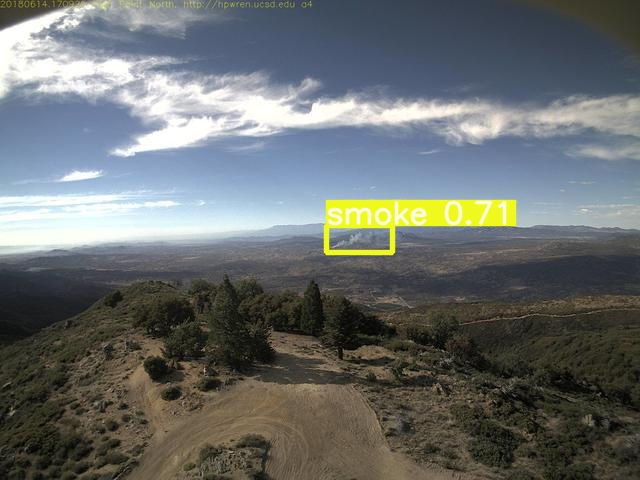

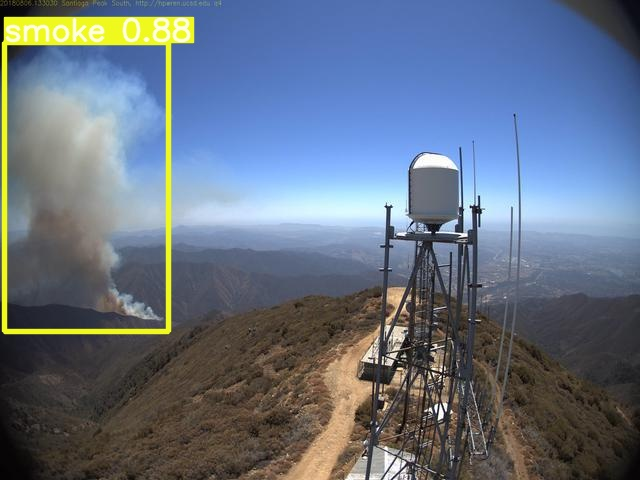

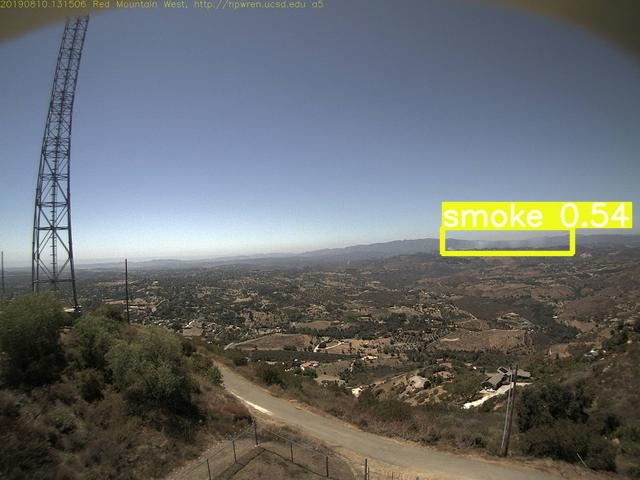

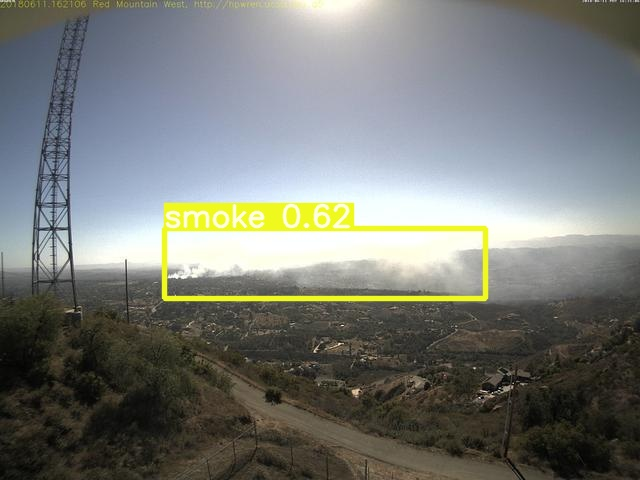

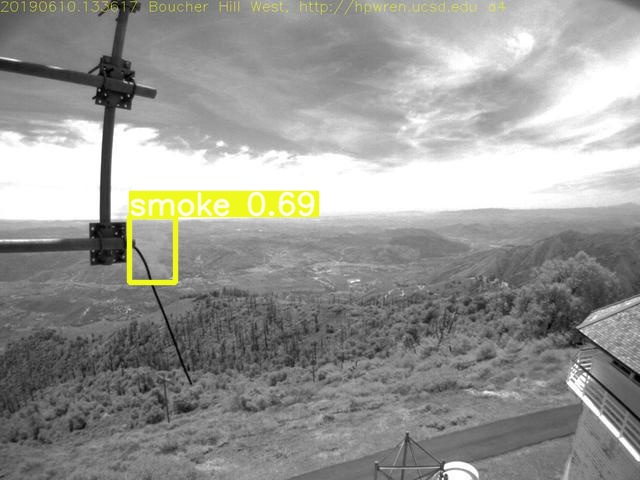

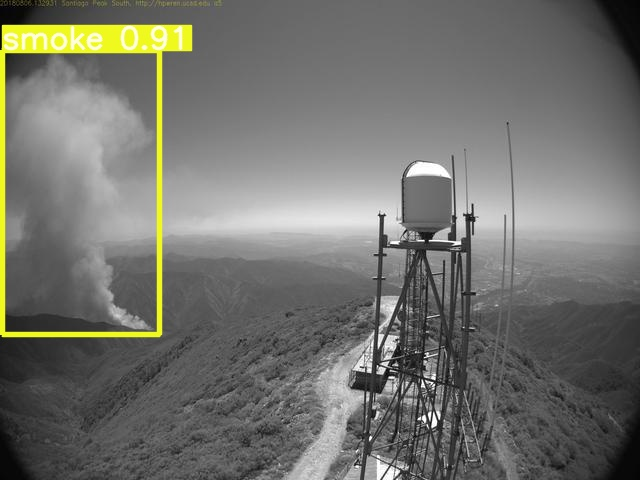

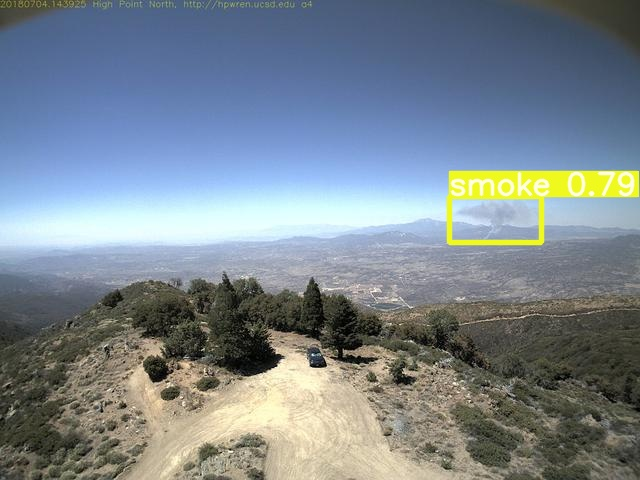

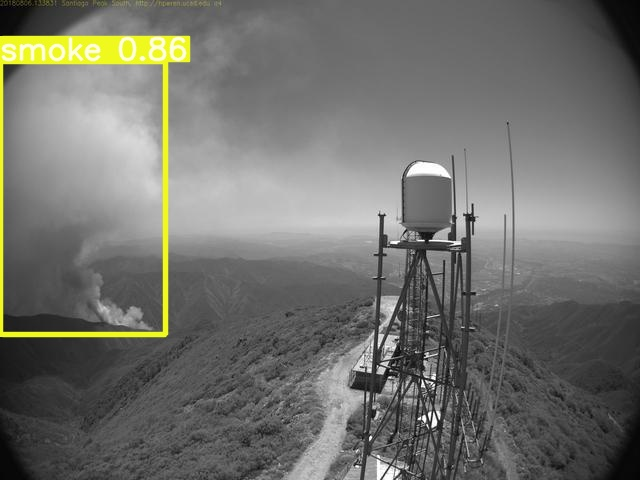

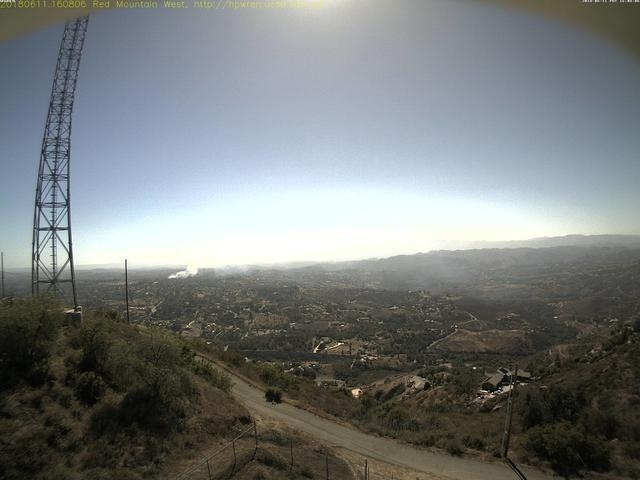

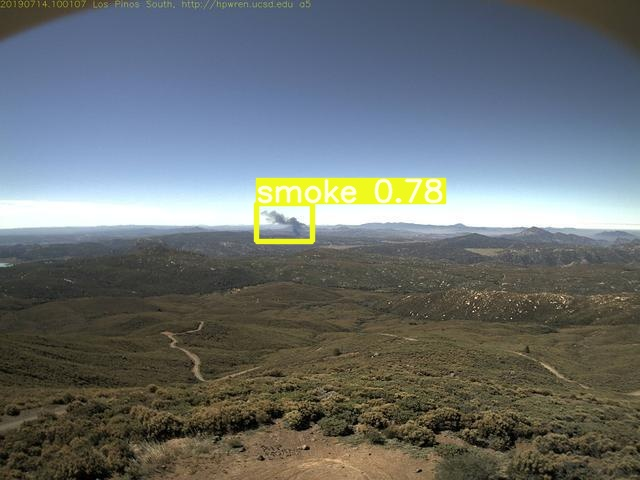

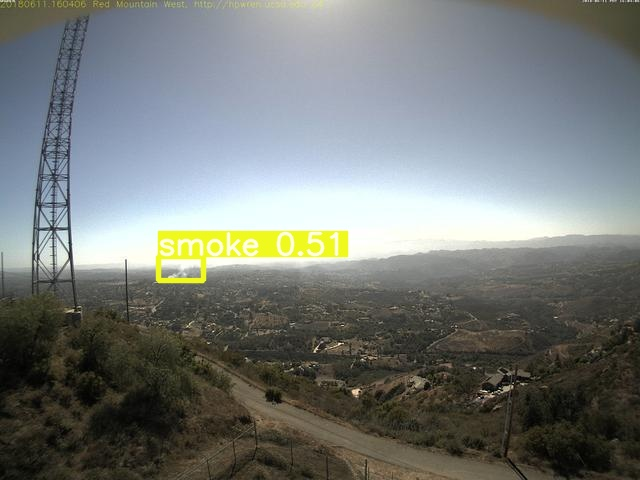

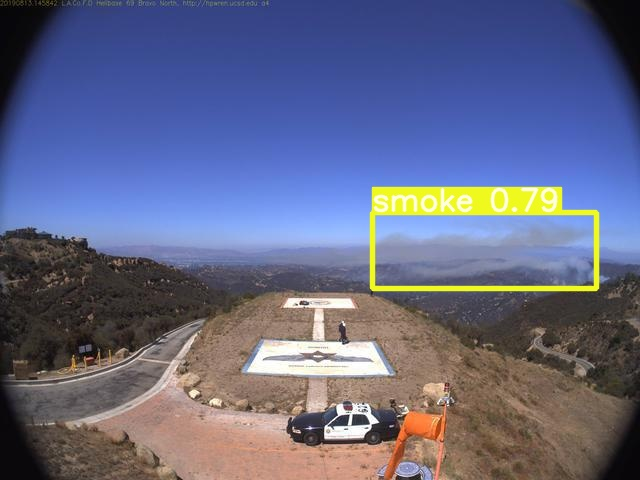

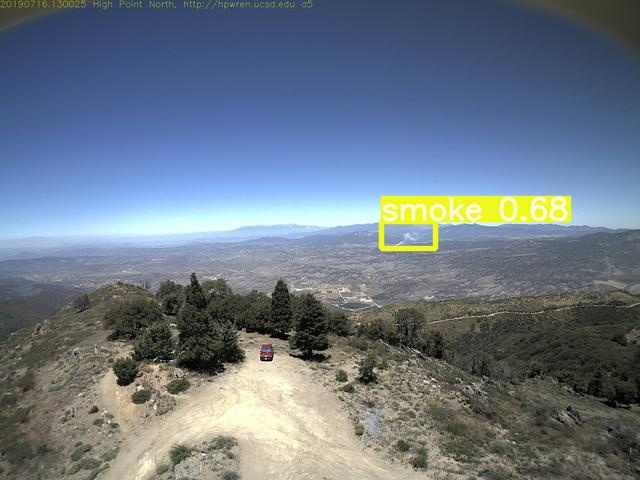

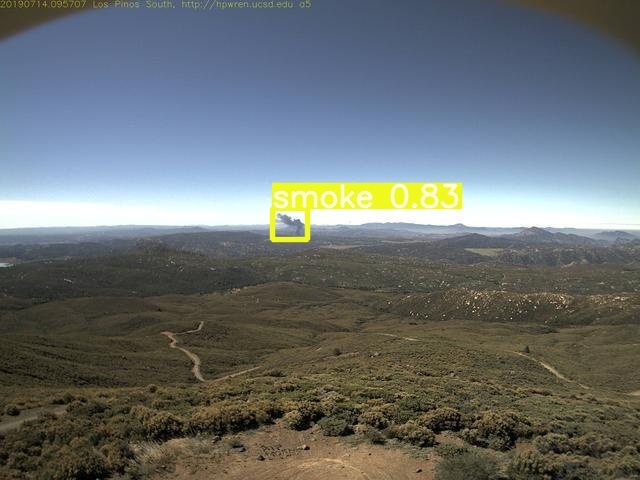

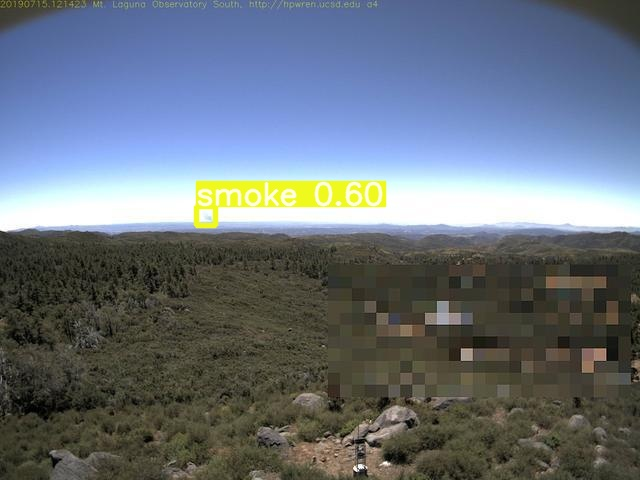

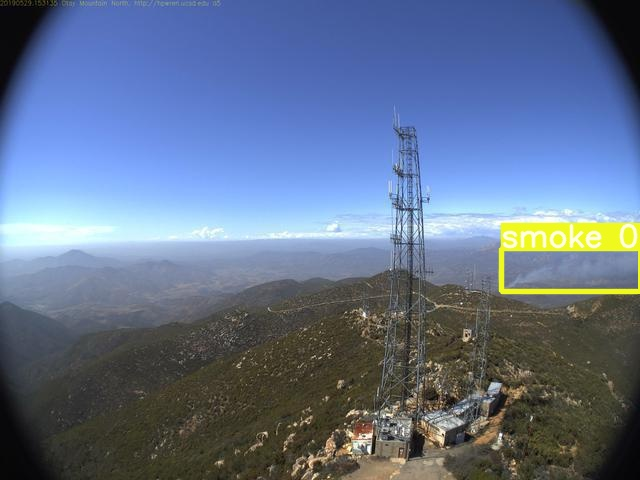

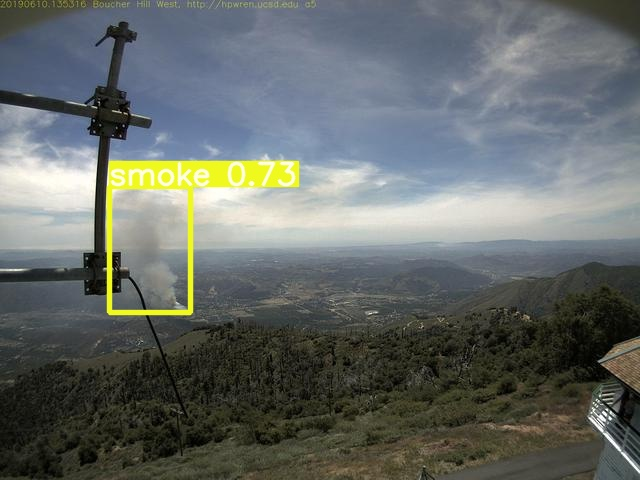

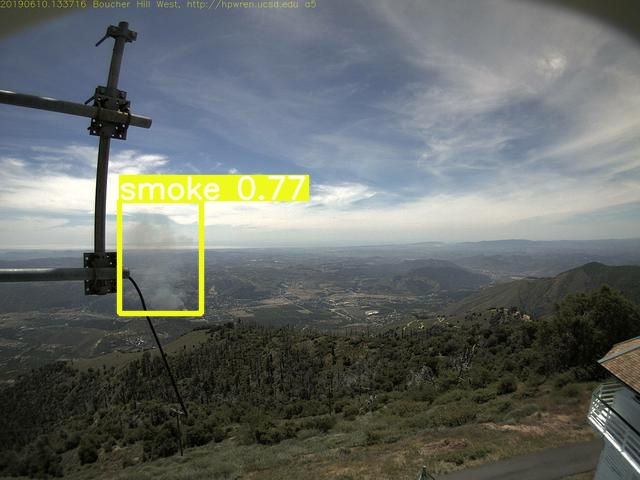

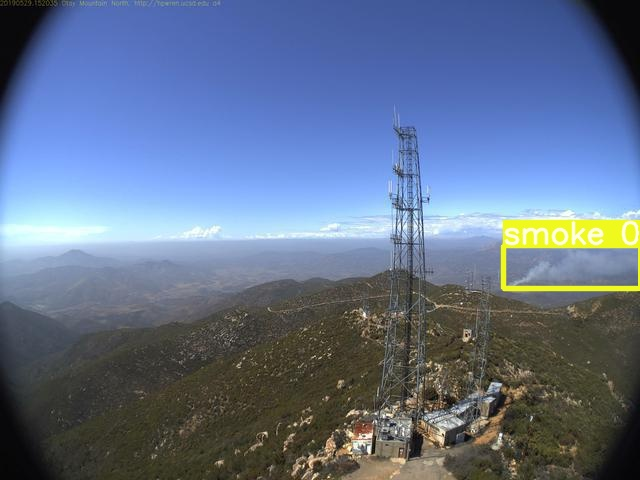

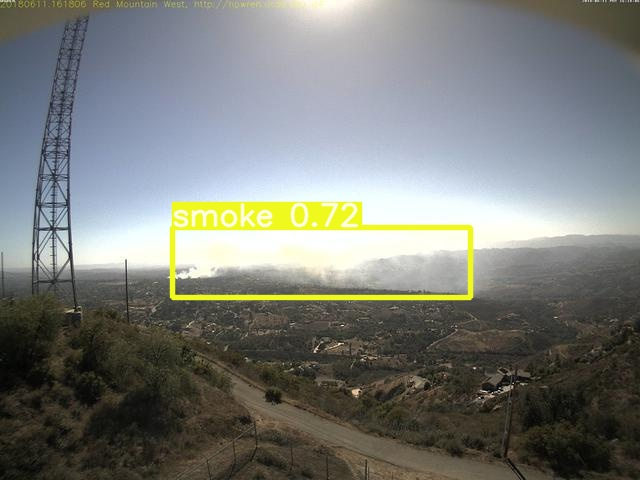

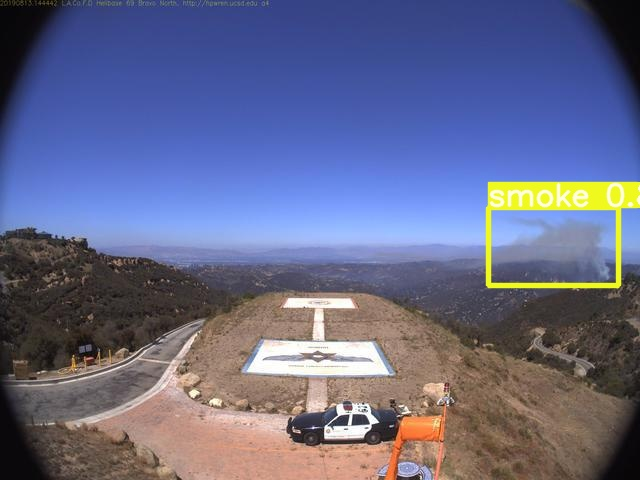

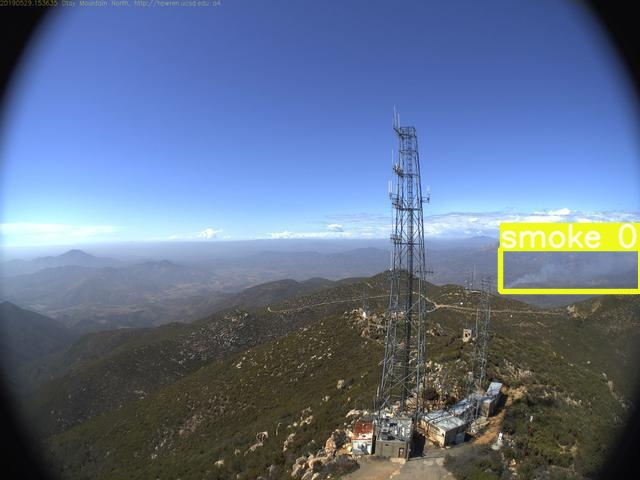

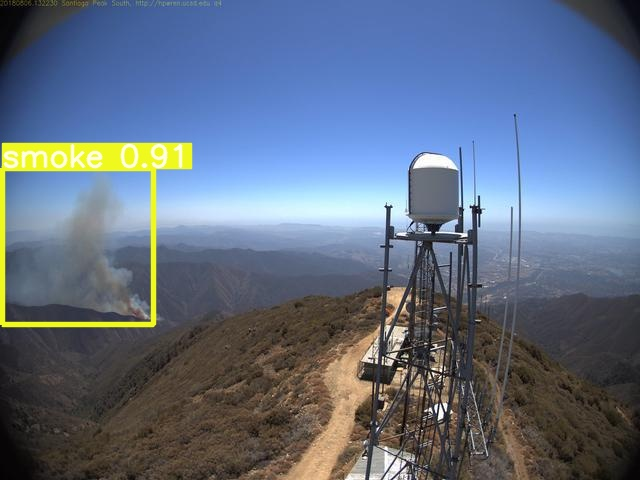

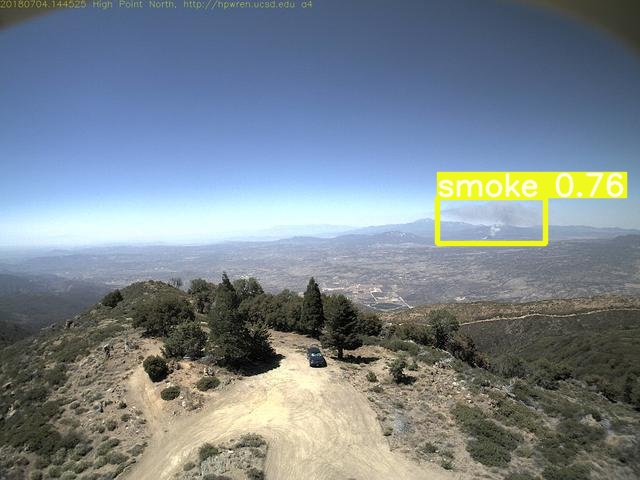

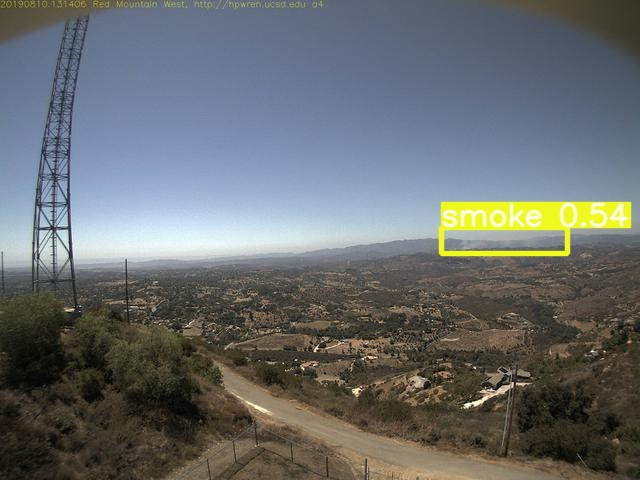

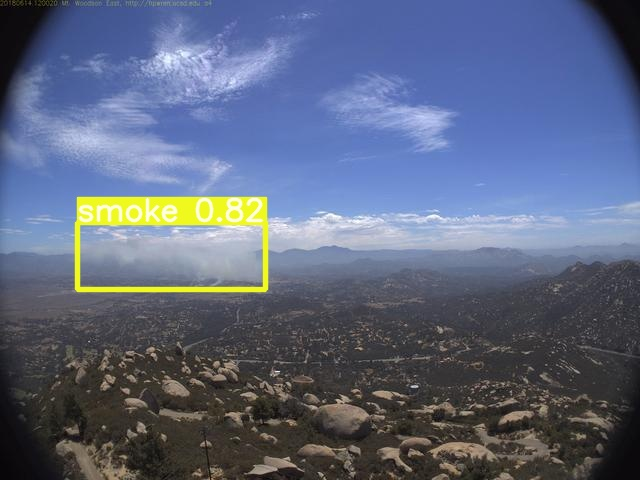

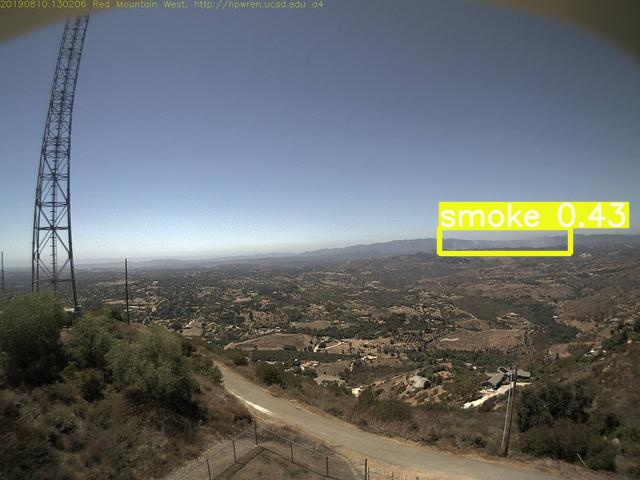

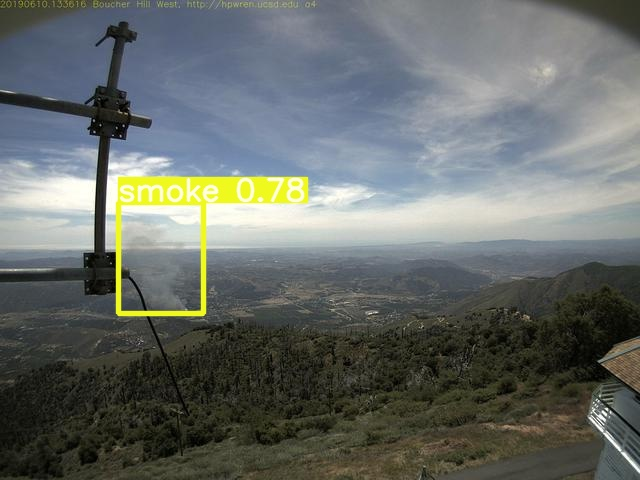

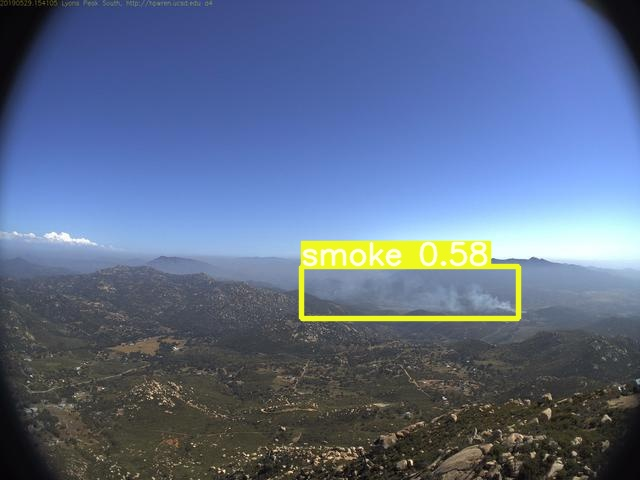

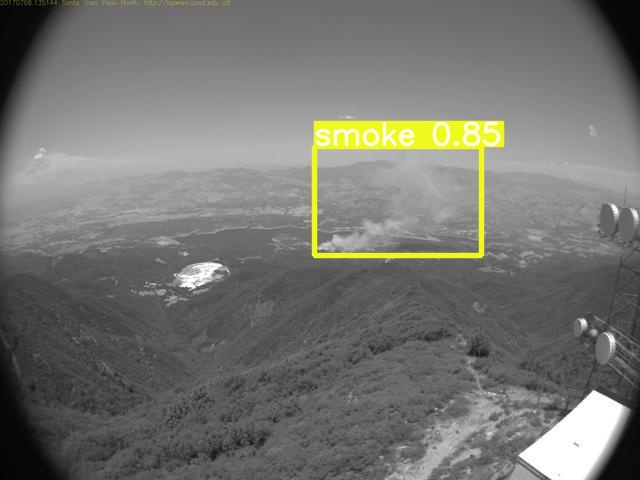

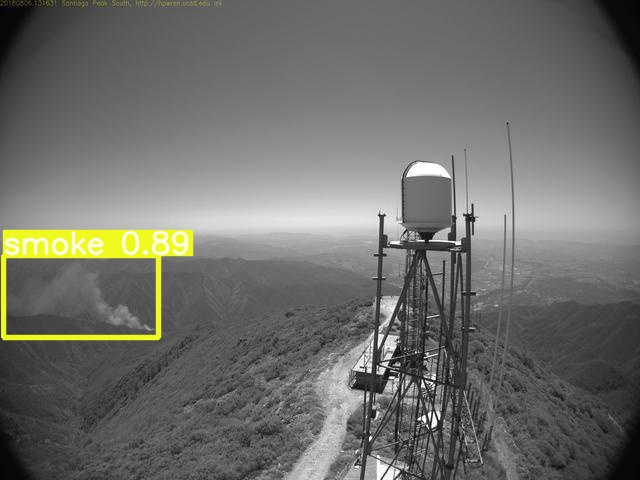

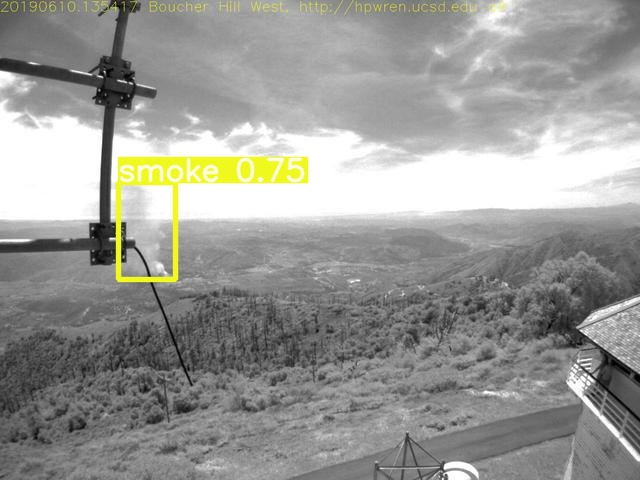

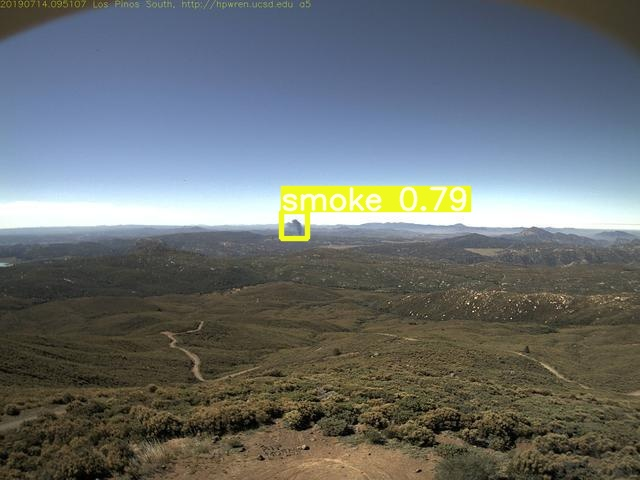

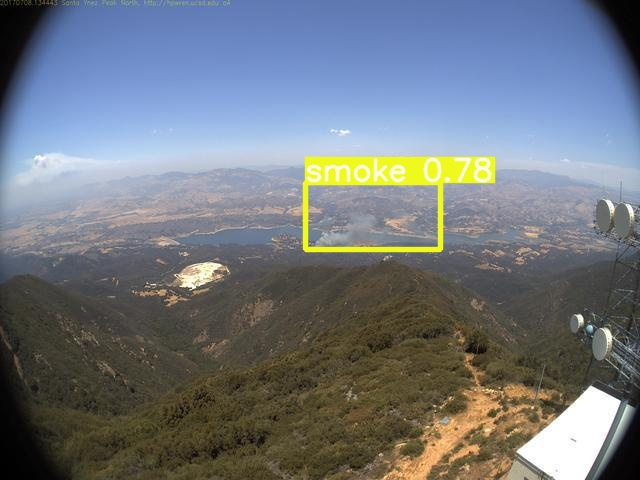

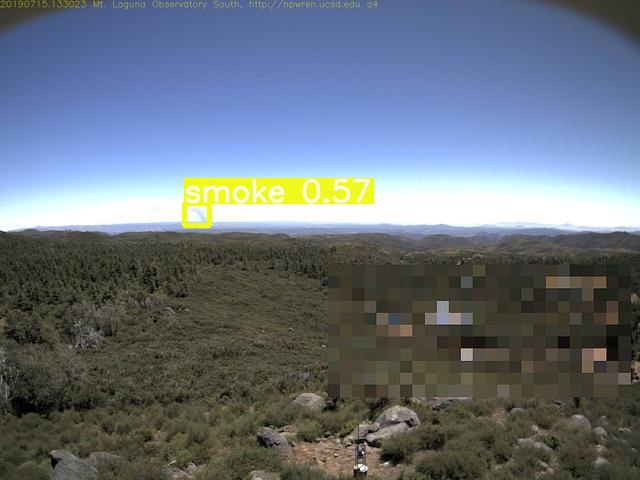

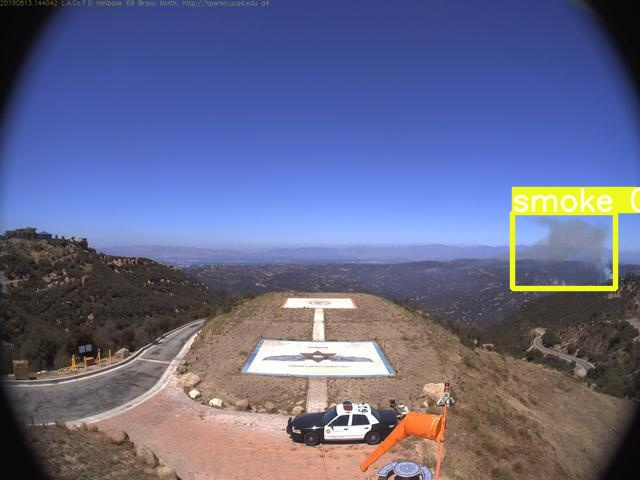

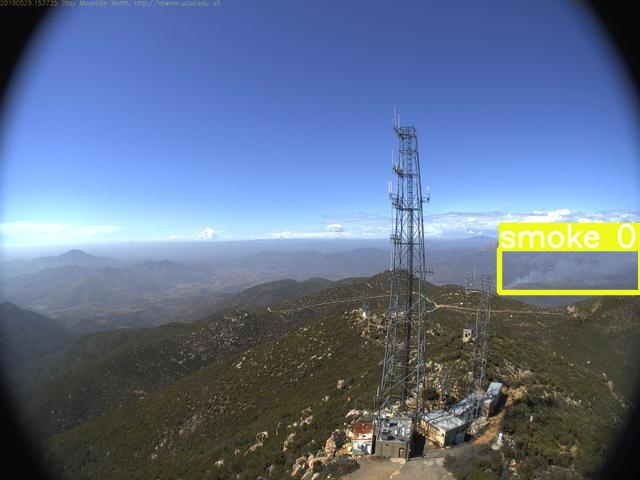

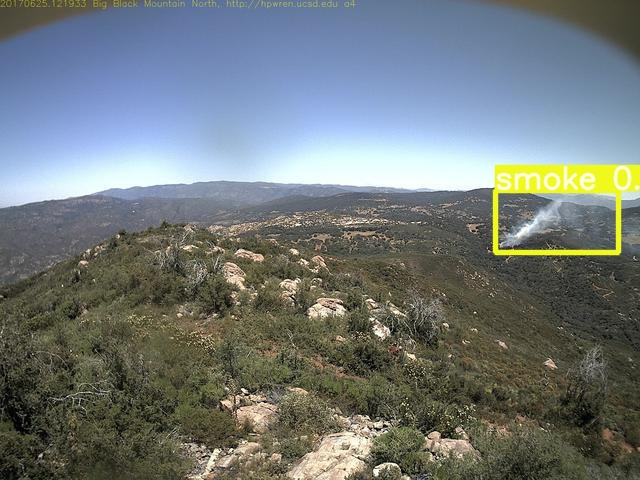

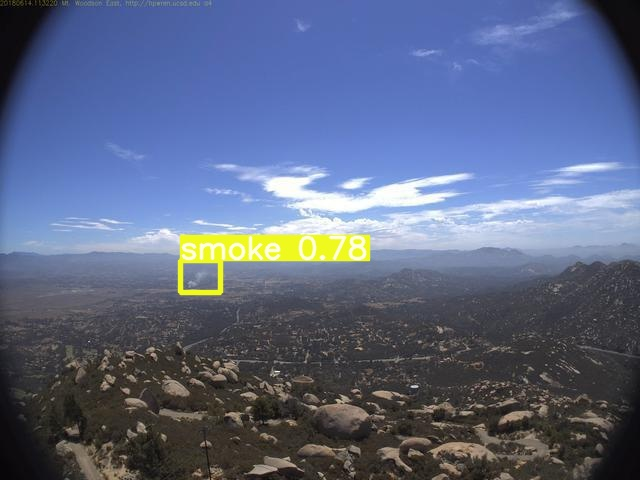

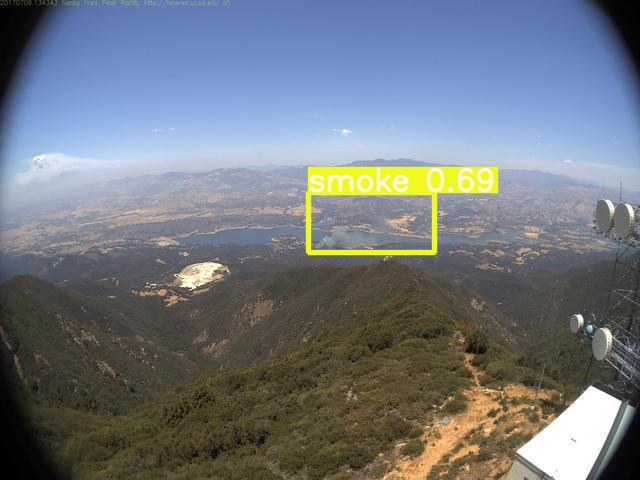

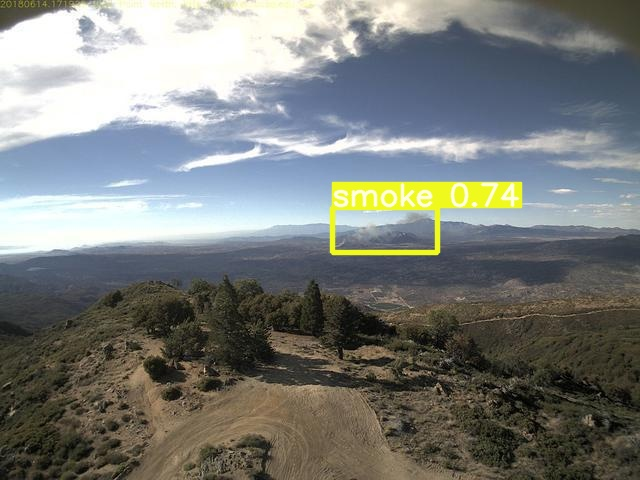

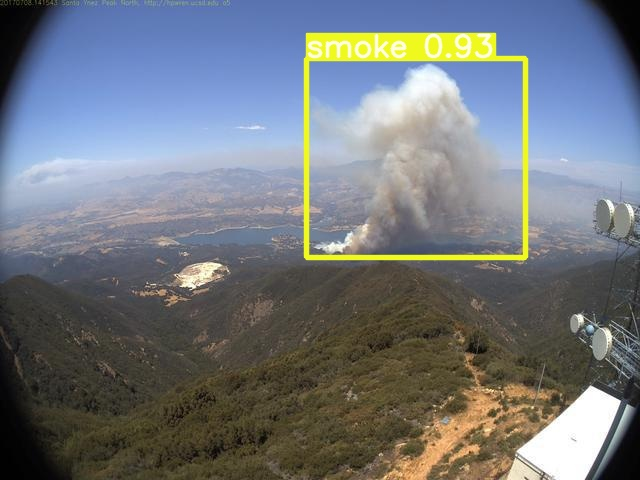

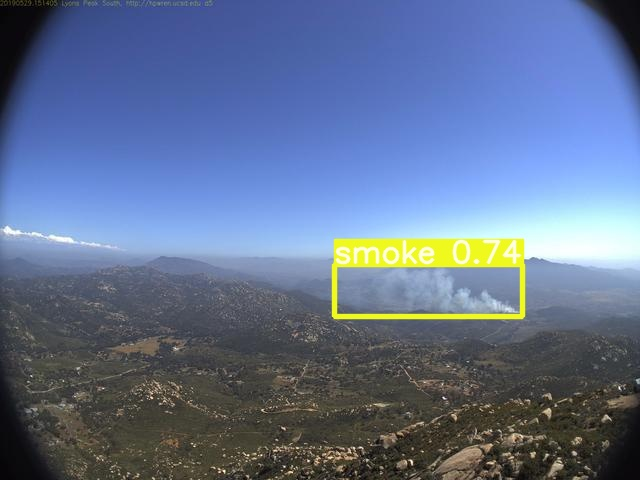

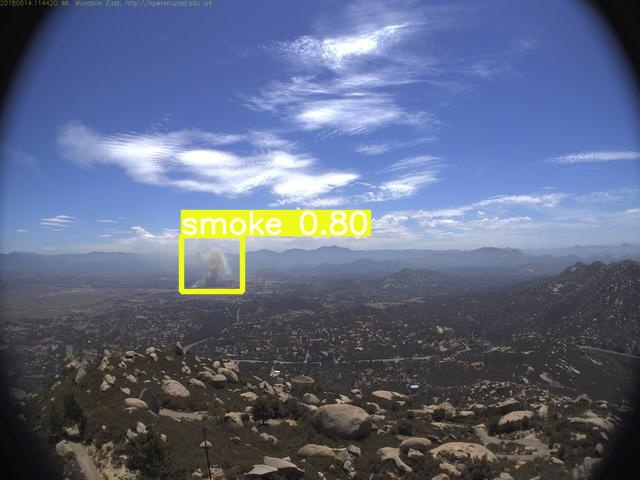

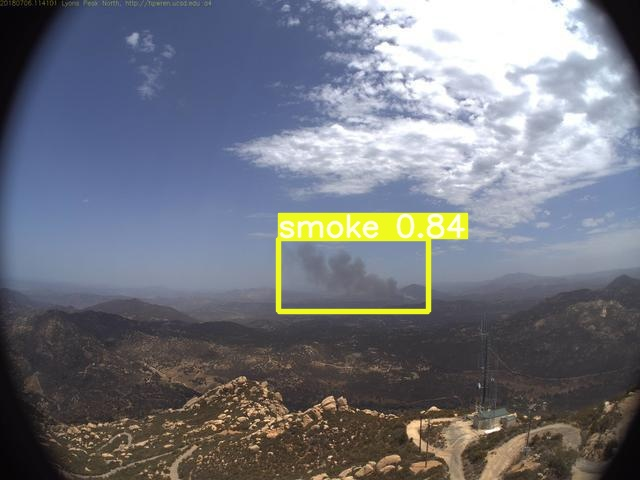

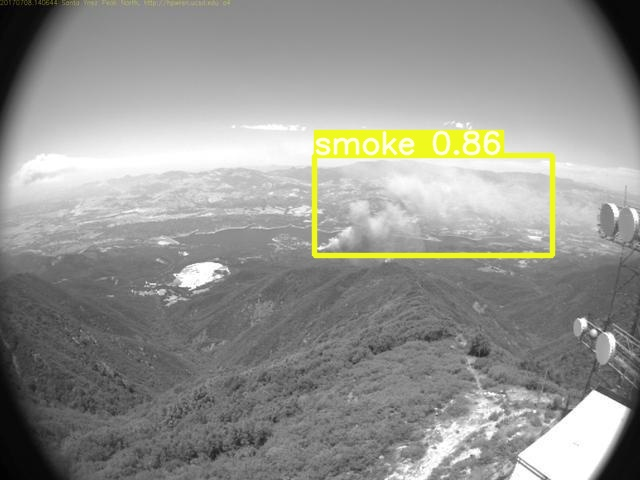

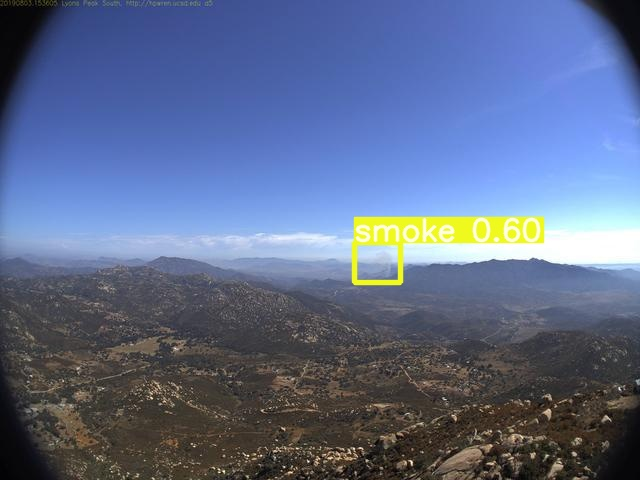

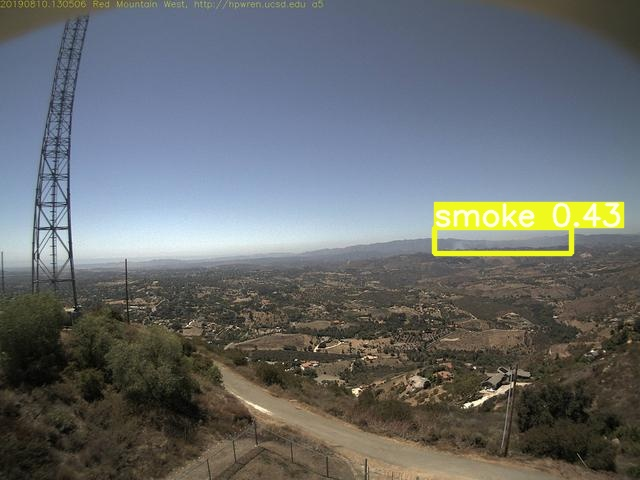

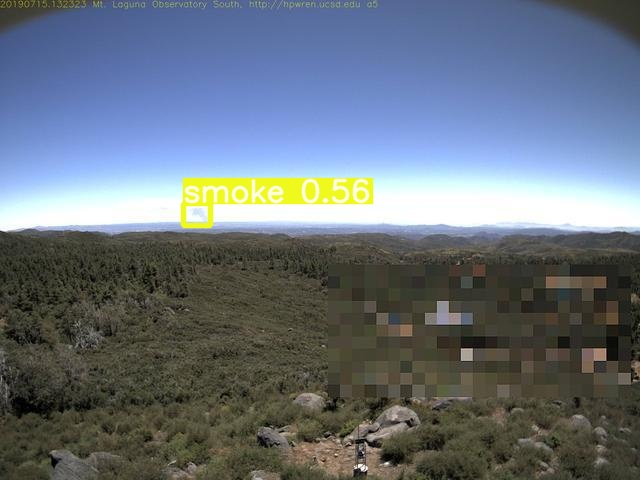

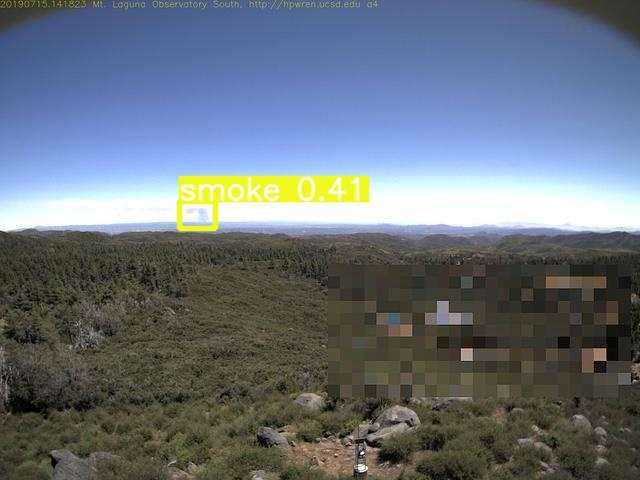

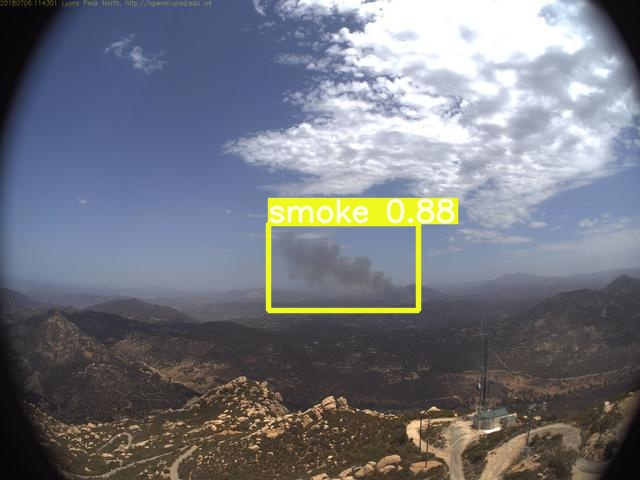

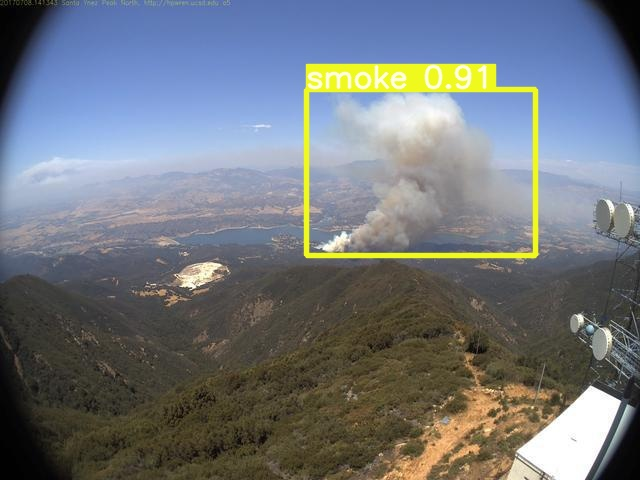

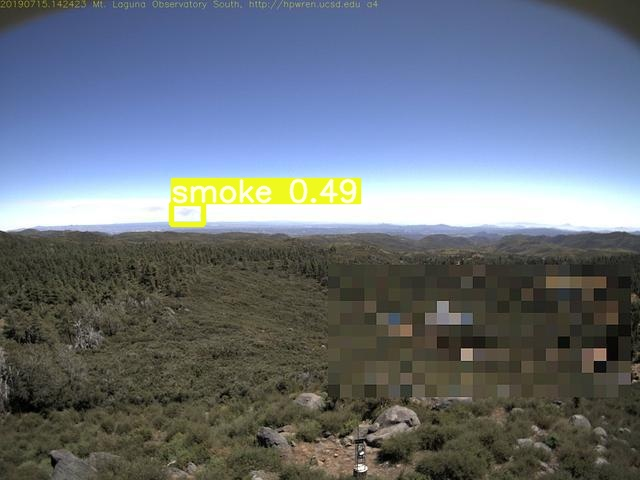

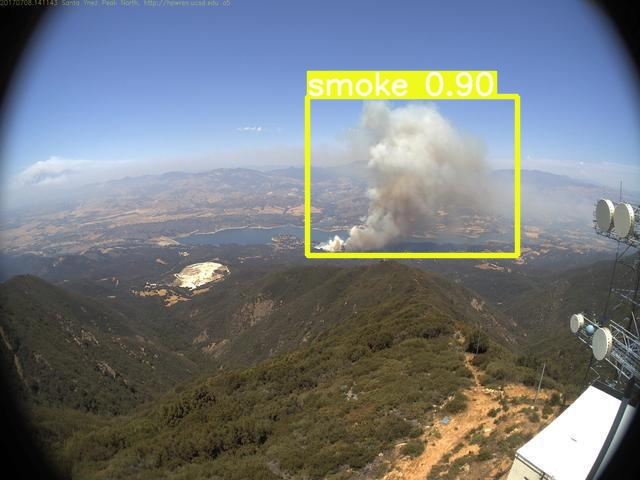

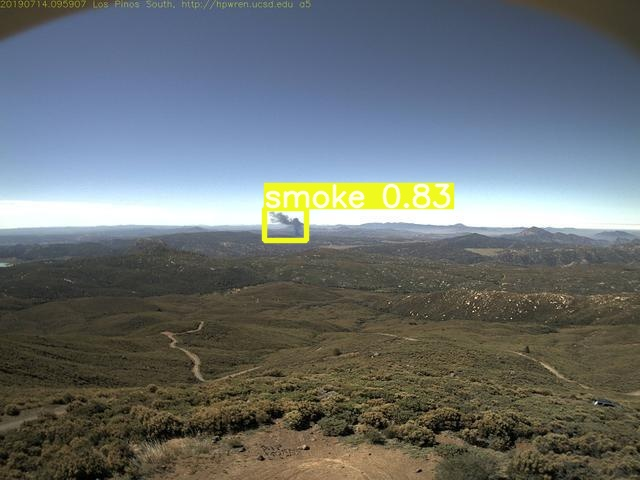

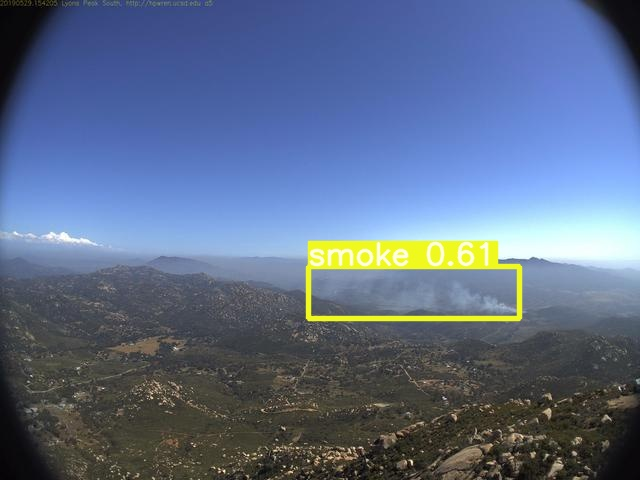

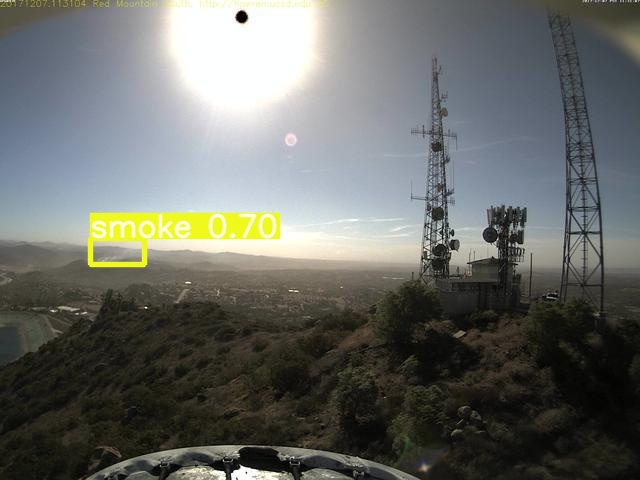

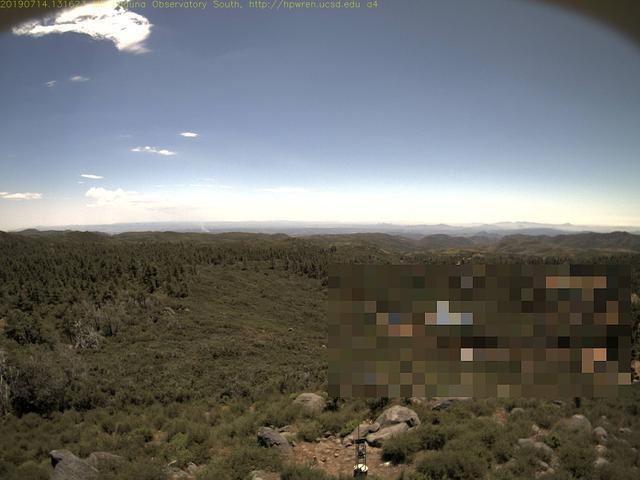

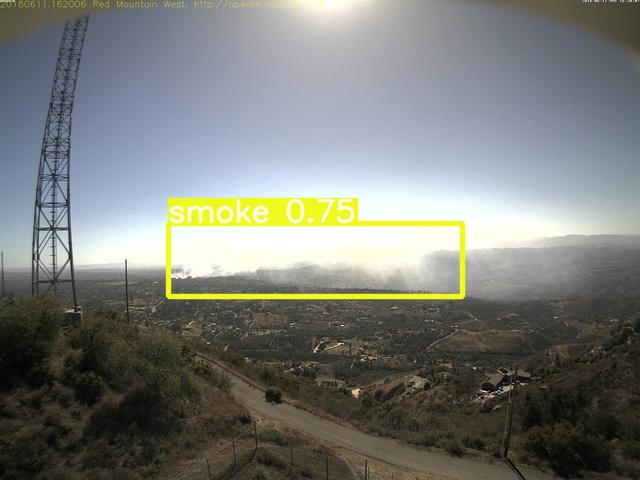

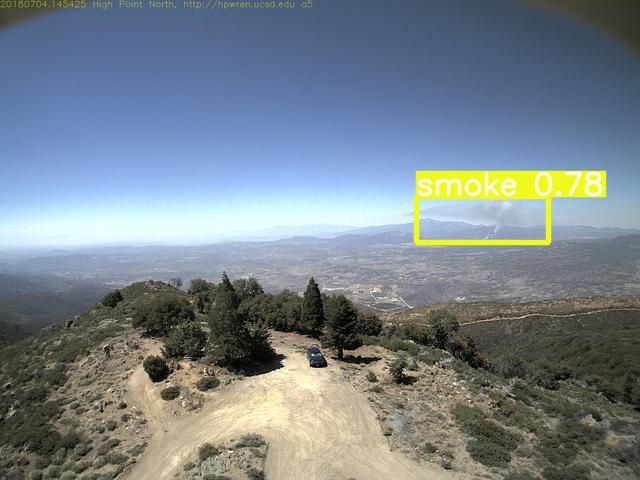

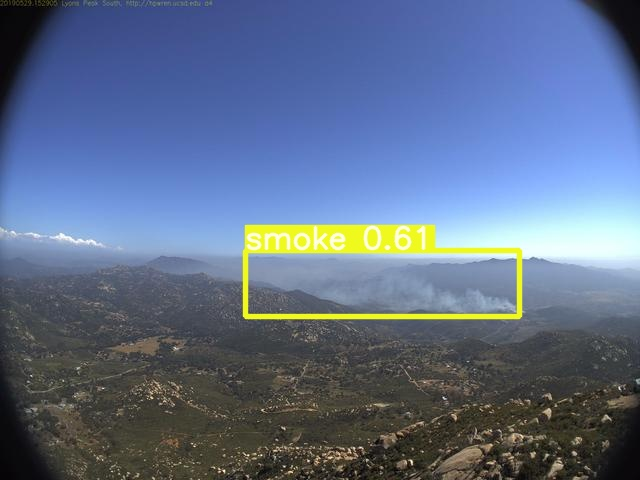

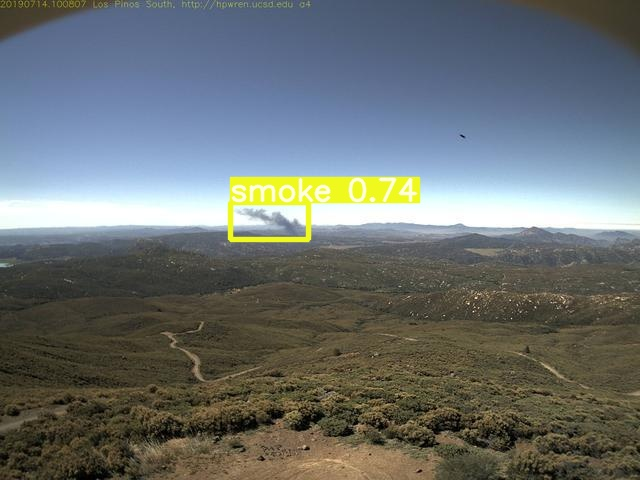

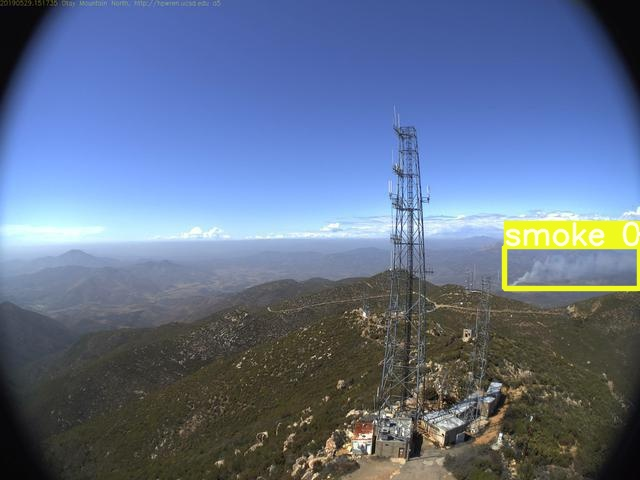

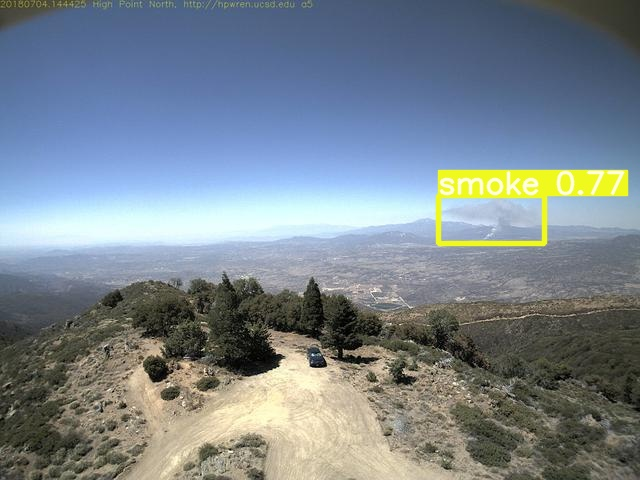

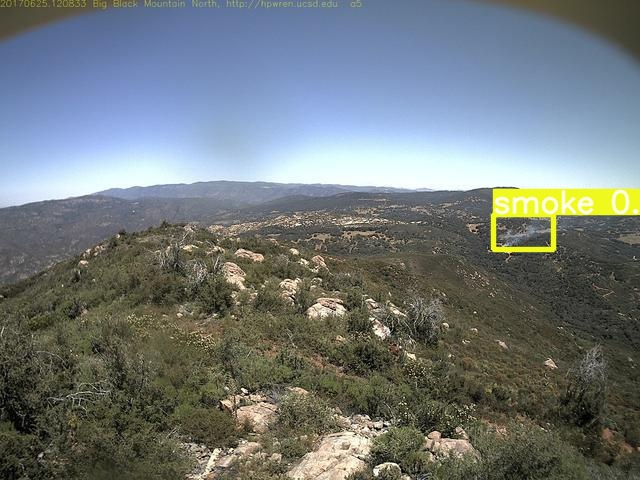

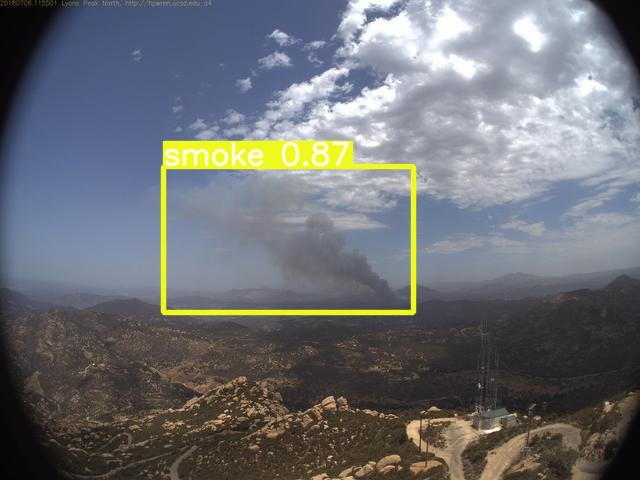

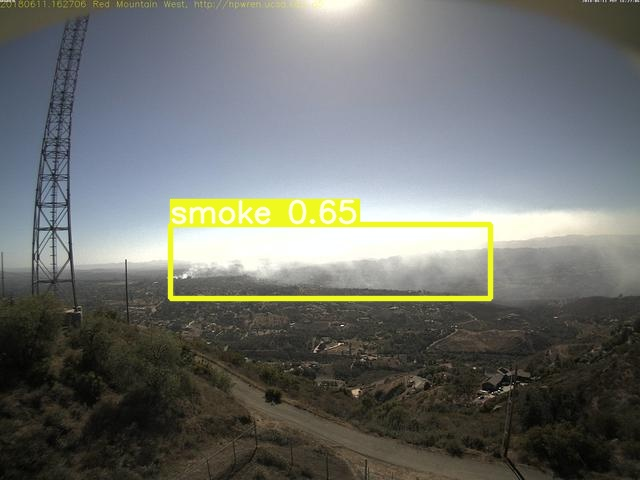

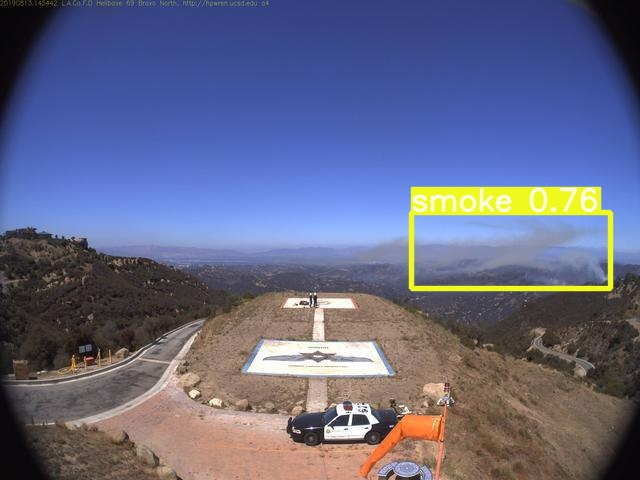

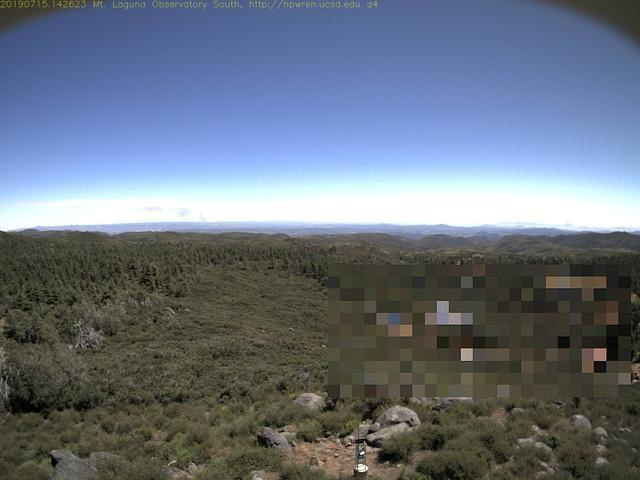

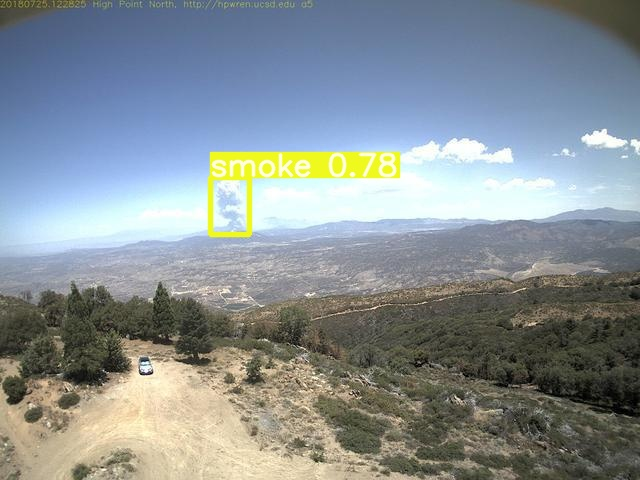

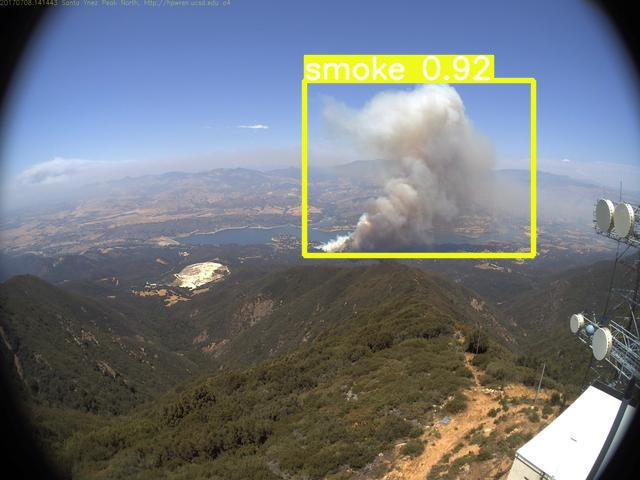

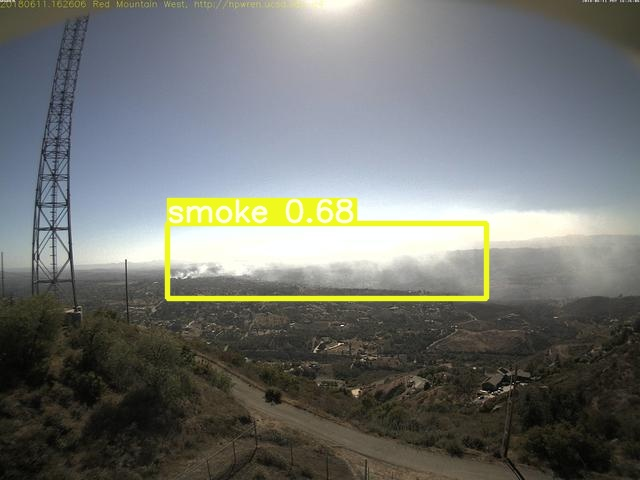

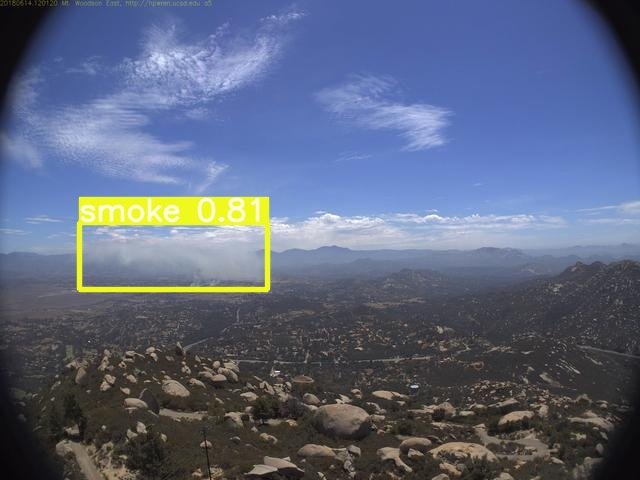

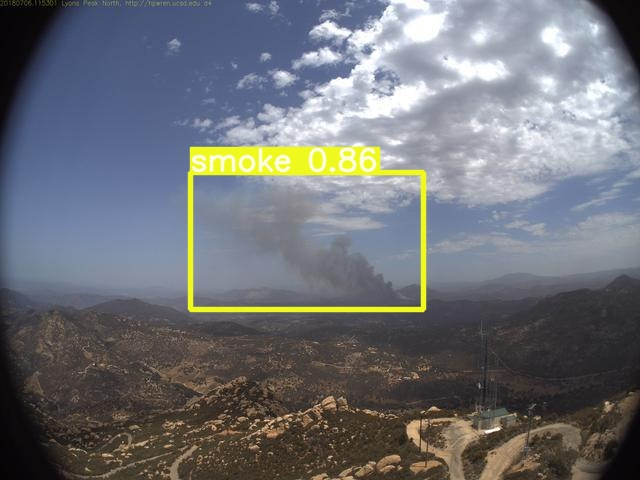

In [19]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'):
    display(Image(filename=imageName))
    print("\n")

In [20]:
!pwd

/content/yolov5


In [25]:
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results3/weights/best.pt --source ../video3.mp4 --conf 0.4

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='../video3.mp4', update=False, view_img=False, weights=['/content/yolov5/runs/train/yolov5s_results3/weights/best.pt'])
Using torch 1.7.1+cu110 CUDA:0 (Tesla T4, 15109MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients
video 1/1 (1/1822) /content/video3.mp4: 384x640 1 smokes, Done. (0.023s)
video 1/1 (2/1822) /content/video3.mp4: 384x640 1 smokes, Done. (0.014s)
video 1/1 (3/1822) /content/video3.mp4: 384x640 1 smokes, Done. (0.014s)
video 1/1 (4/1822) /content/video3.mp4: 384x640 2 smokes, Done. (0.013s)
video 1/1 (5/1822) /content/video3.mp4: 384x640 2 smokes, Done. (0.013s)
video 1/1 (6/1822) /content/video3.mp4: 384x640 2 smokes, Done. (0.013s)
video 1/1 (7/1822) /content/video3.mp4: 384x640 2 smokes, Done. (0.014s)
video 1/1 (8/1822) /content/video